In [2]:
import clip
from PIL import Image
import torch

model, preprocess = clip.load('ViT-B/16', device = f'cuda:{0}')


img = Image.open('test_image.png')
img = preprocess(img).unsqueeze(0).to(0)


In [6]:
model.visual(torch.rand(1,3,224,224).to(0).to(torch.float16))

tensor([[ 6.3037e-01, -4.3408e-01, -3.4033e-01,  3.0176e-01, -1.7664e-01,
          3.3667e-01, -4.2236e-02, -6.1572e-01, -2.3572e-01,  6.5735e-02,
         -4.5105e-02, -6.0645e-01,  2.1057e-02, -8.2336e-02,  1.3708e-01,
         -1.8945e-01, -1.7236e-01,  2.0947e-01,  3.1616e-01, -6.5369e-02,
         -3.0029e-01,  1.2866e-01,  2.1533e-01,  1.0046e-01,  2.1167e-01,
          1.3074e-01, -2.5073e-01,  3.3813e-02,  7.4158e-02,  2.4695e-01,
          3.6548e-01, -7.4585e-02,  2.6733e-01,  3.1647e-02,  2.5024e-01,
         -2.3315e-01, -3.2898e-02, -3.2544e-01, -3.2275e-01, -3.3813e-01,
         -3.4393e-02, -2.7490e-01, -1.1414e-01,  1.8188e-01, -3.4131e-01,
         -3.8281e-01,  3.3740e-01, -1.2549e-01, -1.1627e-01,  1.5710e-01,
         -3.7915e-01, -4.3286e-01,  2.4072e-01,  5.6549e-02, -2.2614e-02,
         -3.0176e-01, -2.2437e-01,  4.4995e-01,  1.3953e-01,  2.9639e-01,
          4.1656e-02,  2.6779e-02,  1.9226e-01,  2.4841e-01, -1.7407e-01,
          5.8624e-02,  1.1847e-01, -2.

In [2]:
model.encode_image(img).shape

torch.Size([1, 512])

In [3]:
model.visual(img.to(torch.float16)).shape

torch.Size([1, 512])

In [4]:
from torchsummary import summary

mod = model.visual.to(torch.float32)
mod.proj = None
summary(mod, (3,224,224));

Layer (type:depth-idx)                        Output Shape              Param #
├─Conv2d: 1-1                                 [-1, 768, 14, 14]         589,824
├─LayerNorm: 1-2                              [-1, 197, 768]            1,536
├─Transformer: 1-3                            [-1, 2, 768]              --
|    └─Sequential: 2-1                        [-1, 2, 768]              --
|    |    └─ResidualAttentionBlock: 3-1       [-1, 2, 768]              7,087,872
|    |    └─ResidualAttentionBlock: 3-2       [-1, 2, 768]              7,087,872
|    |    └─ResidualAttentionBlock: 3-3       [-1, 2, 768]              7,087,872
|    |    └─ResidualAttentionBlock: 3-4       [-1, 2, 768]              7,087,872
|    |    └─ResidualAttentionBlock: 3-5       [-1, 2, 768]              7,087,872
|    |    └─ResidualAttentionBlock: 3-6       [-1, 2, 768]              7,087,872
|    |    └─ResidualAttentionBlock: 3-7       [-1, 2, 768]              7,087,872
|    |    └─ResidualAttentionBlock: 3-

In [5]:

feats = []
def hook(module, input, output):
    feats.append(output)

# ids = [m[1].register_forward_hook(hook) for m in mod.named_modules()]

id = mod.transformer.register_forward_hook(hook)
_ = mod(torch.randn(2,3,224,224).to(0))
id.remove()
# for id in ids:
#     id.remove()

In [12]:
out = feats[0]

out.transpose(0,1)[:,1:].transpose(1,2).reshape(2,768,14,14)

torch.Size([2, 768, 14, 14])

In [12]:
import clip 
import torch

model, preprocess = clip.load('ViT-B/16', device = f'cuda:{0}')

outs = model.visual(torch.rand(1,3,224,224).to(0).to(torch.float16))

In [9]:
model.visual.forward

<function __main__.forward(self, x: torch.Tensor)>

In [8]:
outs = model.visual.forward(torch.rand(1,3,224,224).to(0).to(torch.float16))
outs.shape

TypeError: forward() missing 1 required positional argument: 'x'

In [3]:
model.encode_image(torch.rand(1,3,224,224).to(0).to(torch.float16)).shape

torch.Size([1, 512])

In [3]:
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(0)
text.shape

torch.Size([3, 77])

In [4]:
model.encode_text(clip.tokenize(["a diagram", "a dog", "a cat"]).to(0)).shape

torch.Size([3, 512])

In [5]:
feats = []
feats.append(model.encode_image(torch.rand(1,3,224,224).to(0).to(torch.float16)))
feats.append(model.encode_text(clip.tokenize(["a diagram", "a dog", "a cat"]).to(0)))

### Seeing the forward function in Zegclip

In [1]:
from models import CLIPViT
import torch
import math 

outs = CLIPViT().get_features(torch.rand(1,3,224,224).to(0).to(torch.float16),layers = [11])

c:\Users\sarth\miniconda3\envs\zslearn\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([1, 512])
torch.Size([1, 512, 14, 14])
1


In [2]:
import torch

def d3_to_d4(t):
    n, hw, c = t.size()
    if hw % 2 != 0:
        t = t[:, 1:]
    h = w = int(math.sqrt(hw))
    return t.transpose(1, 2).reshape(n, c, h, w)

def d4_to_d3(t):
    return t.flatten(-2).transpose(-1, -2)

inputs_both = (outs, torch.rand(3,512).to(0))

In [3]:
inputs = inputs_both[0][0]
cls_token = inputs_both[0][1]
text_token = inputs_both[1]

len(inputs), cls_token.shape, text_token.shape

(2, torch.Size([1, 512]), torch.Size([3, 512]))

In [5]:
inputs[1].shape

torch.Size([1, 512, 14, 14])

In [13]:
x = []
for stage_ in inputs[:1]:
    x.append(d4_to_d3(stage_) if stage_.dim() > 3 else stage_)
x.reverse()

In [14]:
def get_qs(q, cls):
    # q = [q.cls, q]
    C, dim = q.shape
    bs, _ = cls.shape
    q = q.expand(bs, -1, -1)
    q1 = torch.einsum("bd,bcd->bcd", cls, q)
    q_ = torch.concat((q1, q), dim=-1)
    return q_

get_qs(text_token, cls_token).shape

torch.Size([1, 3, 1024])

In [6]:
text_token.expand(1,-1,-1).shape

torch.Size([1, 3, 512])

In [26]:
outs[0][1].shape

torch.Size([1, 512, 14, 14])

In [1]:
from models import SegDecoder
import torch 

inputs_both = [
    [(torch.rand(1,768,14,14).to(0),torch.rand(1,512,14,14).to(0)),torch.rand(1,512).to(0)],
    torch.rand(3,512).to(0)
]

decoder = SegDecoder(224,768,[0,1],[0,1]).to(0)

decoder(inputs_both)

c:\Users\sarth\miniconda3\envs\zslearn\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([1, 3, 224, 224])


In [9]:
import clip
import torch

image_encoder = clip.load('RN50', device = f'cuda:{0}')[0].visual

In [10]:
modules = dict(image_encoder.named_children())

In [1]:
from models import CLIPResnet
import torch

feats = CLIPResnet().get_features(torch.rand(1,3,224,224).to(0))

c:\Users\sarth\miniconda3\envs\zslearn\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
for f in feats:
    print(f.shape)

feats.reverse()

torch.Size([1, 256, 56, 56])
torch.Size([1, 512, 28, 28])
torch.Size([1, 1024, 14, 14])
torch.Size([1, 2048, 7, 7])


In [3]:
from models import Decoder

decoder = Decoder(10).to(0).to(torch.float16)

decoder(feats).shape

torch.Size([1, 10, 224, 224])

In [4]:
import clip

In [3]:
from models import CLIPResNet, CLIPVisionTransformer
import torch 

model = CLIPResNet(
    layers=[3, 4, 6, 3],
    output_dim=1024,
    heads = 8,
    input_resolution=512
)



In [2]:
outs = model.get_features(torch.rand(1,3,512,512))

for o in outs:
    print(o.shape)

torch.Size([1, 256, 128, 128])
torch.Size([1, 512, 64, 64])
torch.Size([1, 1024, 32, 32])
torch.Size([1, 2048, 16, 16])


In [11]:
from models import CLIPVisionTransformer
import torch 

model = CLIPVisionTransformer(512,16,out_indices=[11,10])

In [12]:
outs = model(torch.rand(1,3,512,512))

2


In [ ]:
import yaml

with open('trial_config.yaml', 'r') as f:
    file = yaml.safe_load(f)

file

In [ ]:
from data import cityscapes_dataset_train

img, target = cityscapes_dataset_train.__getitem__(10)

import matplotlib.pyplot as plt


plt.imshow(img.permute(1,2,0).numpy())
plt.show()
plt.imshow(target.permute(1,2,0).numpy())

In [9]:
import os 
from os.path import join
import pandas as pd

source = r'cityscapes_dataset'
folders = ['gtFine','leftImg8bit', 'leftImg8bit_foggy']
subset = 'train'

frames = []
for place_folder in os.listdir(join(source, folders[1], subset)):
    for file in os.listdir(join(source, folders[1], subset, place_folder)):
        place_name = place_folder
        image_number = '_'.join(file.split('_')[1:3])
        frames.append(pd.DataFrame(
            {
                'image': join(source, folders[1], subset, place_folder,file),
                'foggy_image': join(source, folders[2], subset, place_folder,f'{place_name}_{image_number}_leftImg8bit_foggy_beta_0.02.png'),
                'target':join(source, folders[0], subset, place_folder, f'{place_name}_{image_number}_gtFine_color.png')
            },
            index=[0]
        ))

df = pd.concat(frames).reset_index(drop = True)

In [10]:
df.head()

,image,foggy_image,target
0,cityscapes_dataset\leftImg8bit\train\aachen\aa...,cityscapes_dataset\leftImg8bit_foggy\train\aac...,cityscapes_dataset\gtFine\train\aachen\aachen_...
1,cityscapes_dataset\leftImg8bit\train\aachen\aa...,cityscapes_dataset\leftImg8bit_foggy\train\aac...,cityscapes_dataset\gtFine\train\aachen\aachen_...
2,cityscapes_dataset\leftImg8bit\train\aachen\aa...,cityscapes_dataset\leftImg8bit_foggy\train\aac...,cityscapes_dataset\gtFine\train\aachen\aachen_...
3,cityscapes_dataset\leftImg8bit\train\aachen\aa...,cityscapes_dataset\leftImg8bit_foggy\train\aac...,cityscapes_dataset\gtFine\train\aachen\aachen_...
4,cityscapes_dataset\leftImg8bit\train\aachen\aa...,cityscapes_dataset\leftImg8bit_foggy\train\aac...,cityscapes_dataset\gtFine\train\aachen\aachen_...


In [11]:
from PIL import Image

for i in range(len(df)):
    images = df.iloc[i]
    try:
        im = Image.open(images.image)
        im.verify()
        im.close()
    except:
        print(images.image)
    try:
        im = Image.open(images.foggy_image)
        im.verify()
        im.close()
    except:
        print(images.foggy_image)
    try:
        im = Image.open(images.target)
        im.verify()
        im.close()
    except:
        print(images.target)

In [12]:
df.to_csv(f'dataset/cityscape_{subset}.csv', index=False)

In [2]:
from models import CLIPResNet, CLIPVisionTransformer
import yaml
import torch
args = yaml.safe_load(open('trial_config.yaml', 'r'))

resnet = CLIPResNet(
        layers = args['Resnet']['layers'],
        output_dim = args['Resnet']['output_dim'],
        heads = args['Resnet']['heads'],
        input_resolution = args['img_size'],
        width = args['Resnet']['width'],
        pretrained = args['Resnet']['pretrained']
    )

vit = CLIPVisionTransformer(
        input_resolution = args['img_size'],
        patch_size = args['VIT']['patch_size'],
        width = args['VIT']['width'],
        layers = args['VIT']['layers'],
        heads = args['VIT']['heads'],
        output_dim = args['VIT']['output_dim'],
        drop_path_rate = args['VIT']['drop_path_rate'],
        out_indices = args['VIT']['out_indices'],
        get_embeddings = args['VIT']['get_embeddings'],
        pretrained = args['VIT']['pretrained']
    )

Resize the pos_embed shape from torch.Size([50, 2048]) to torch.Size([257, 2048])
[] [] are misaligned params in resnet
Resize the pos_embed shape from torch.Size([197, 768]) to torch.Size([1025, 768])
[] [] are misaligned params in vision transformer


In [5]:
outs = resnet.get_features(torch.rand(1,3,512,512))
for o in outs:
    print(o.shape)

torch.Size([1, 256, 128, 128])
torch.Size([1, 512, 64, 64])
torch.Size([1, 1024, 32, 32])
torch.Size([1, 2048, 16, 16])


In [11]:
vit_outs = vit(torch.rand(1,3,512,512))
vit_outs[0][0].shape, vit_outs[1].shape

1


(torch.Size([1, 512, 32, 32]), torch.Size([1, 512]))

#### Finding out the classes in the cityscapes dataset

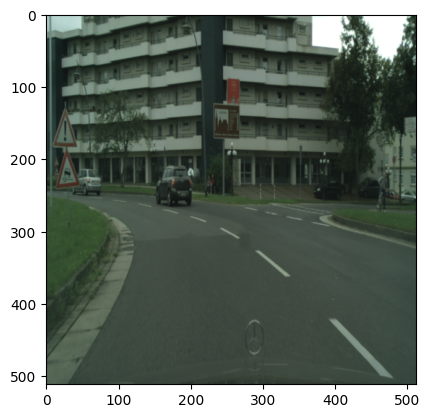

In [1]:
from data import dataset, labels
import torch
from matplotlib import pyplot as plt
import numpy as np

data = dataset('dataset/cityscape_train.csv', kaggle = False)

image, foggy, gt = data.__getitem__(0)


# gt = gt.permute(1,2,0)[:,:,:3]
# gt_255 = (gt*255).to(torch.int)
plt.imshow(image.permute(1,2,0))
# plt.imshow(gt)
# plt.show()
# plt.imshow(gt_255)

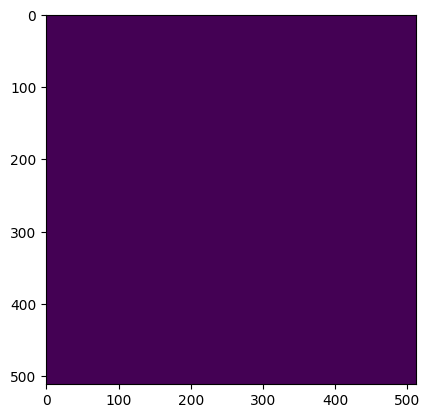

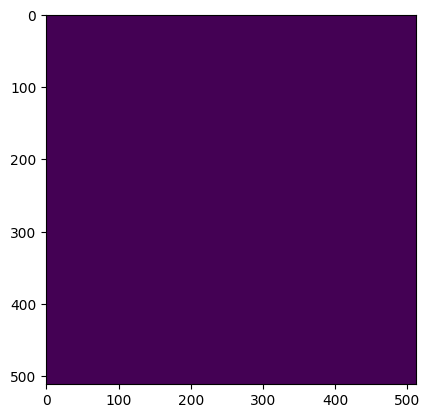

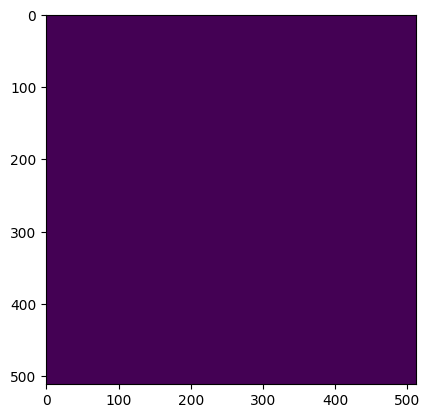

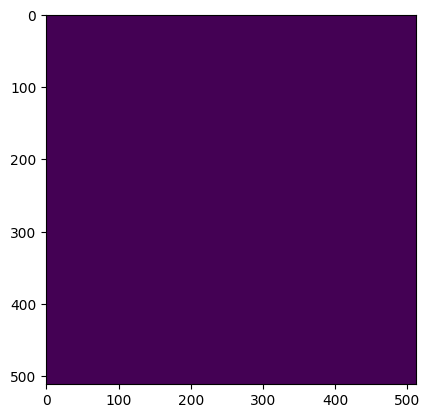

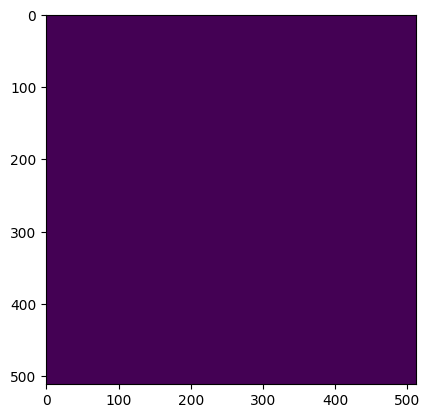

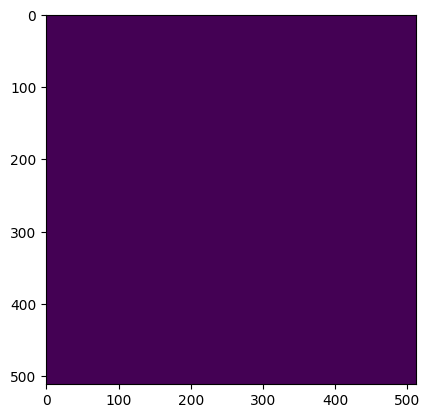

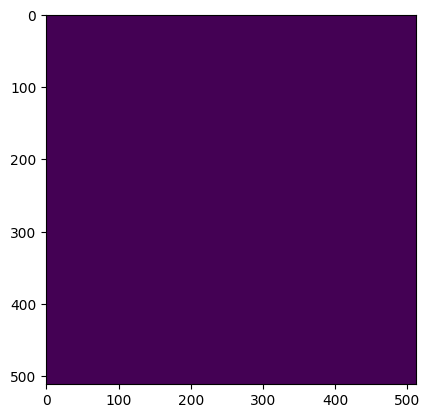

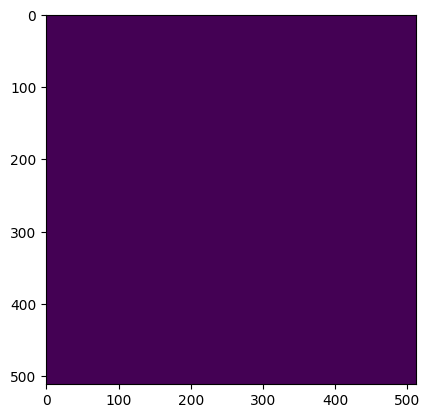

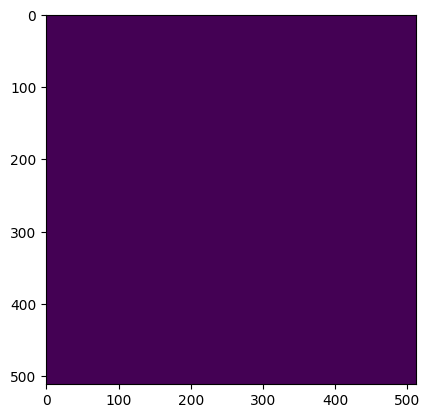

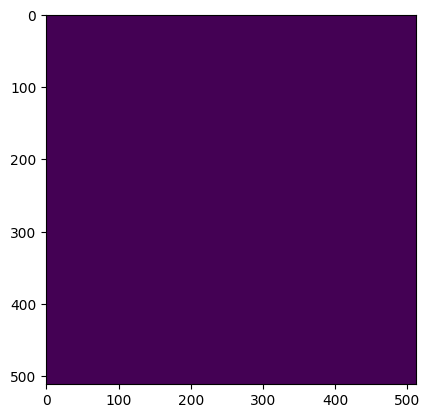

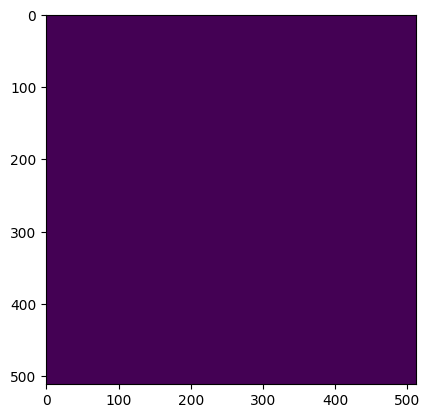

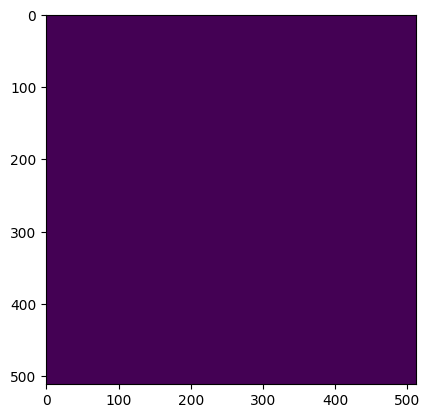

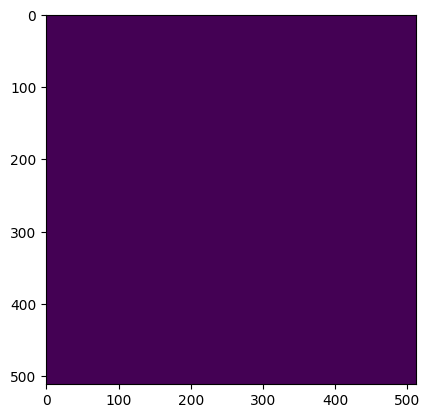

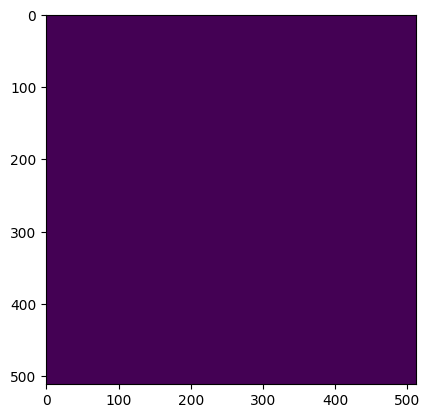

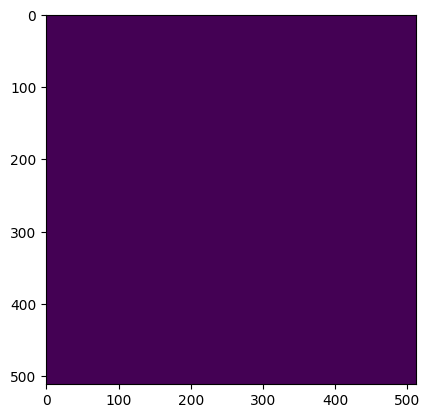

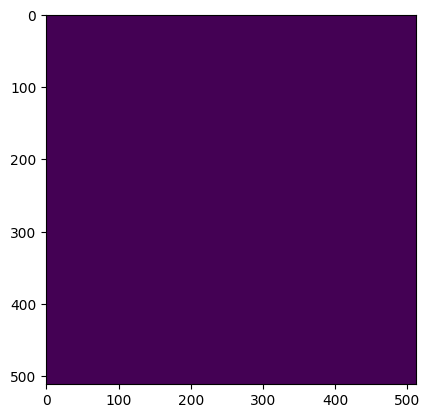

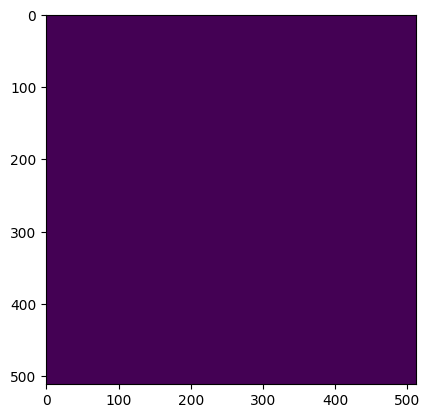

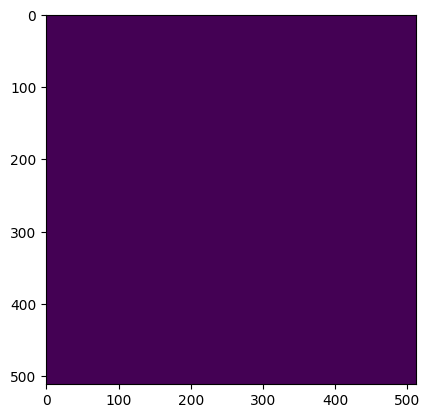

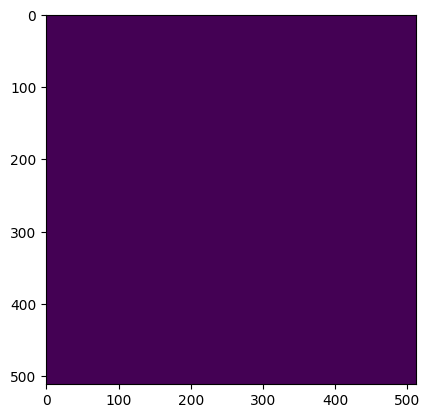

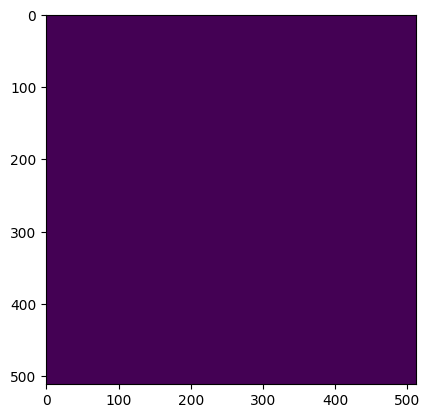

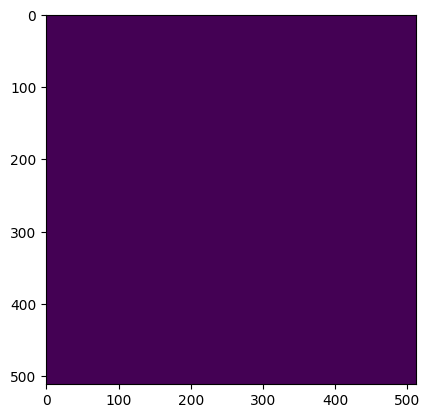

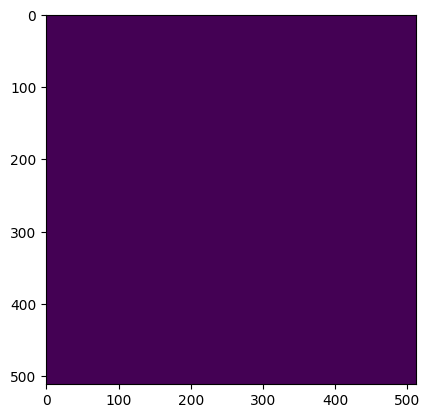

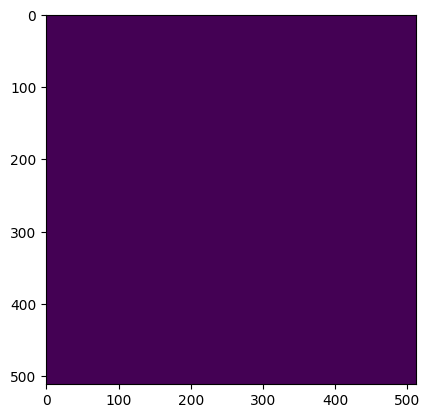

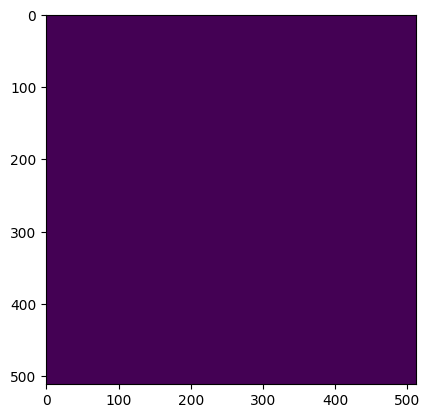

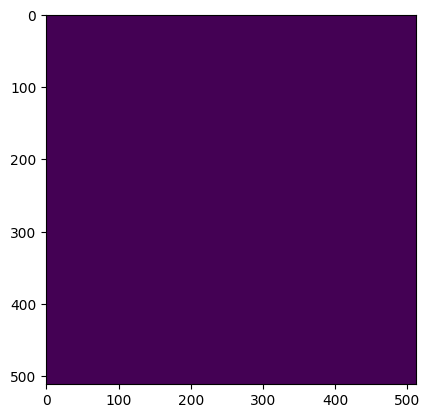

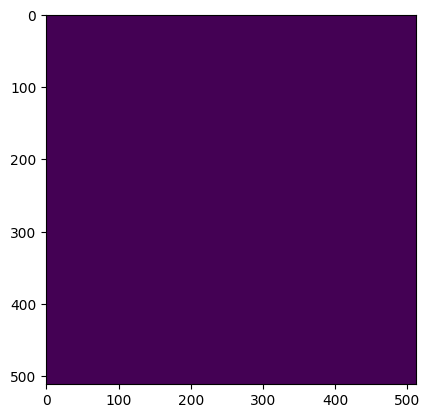

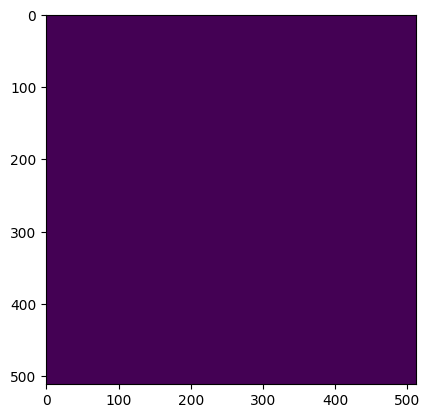

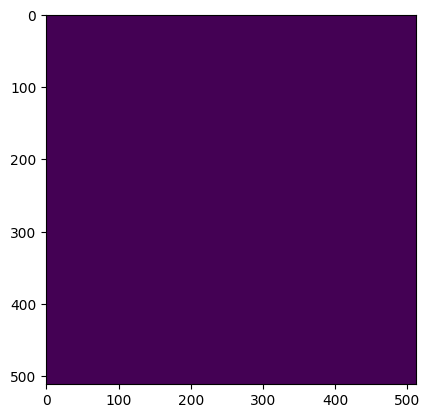

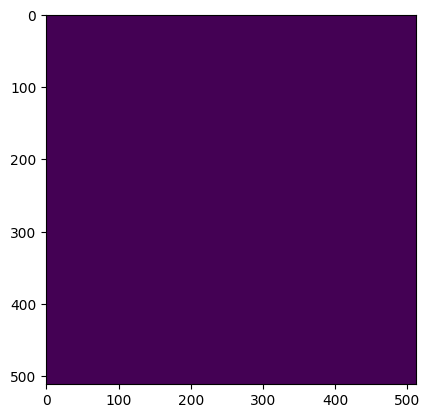

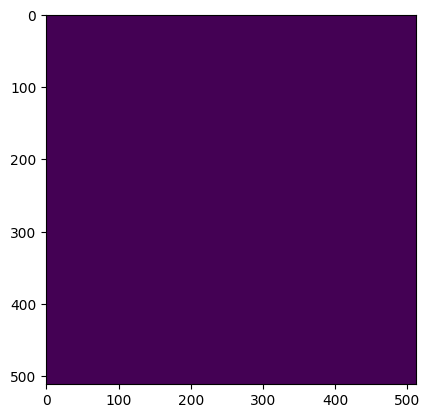

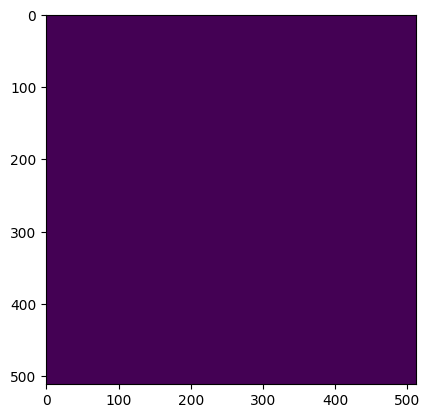

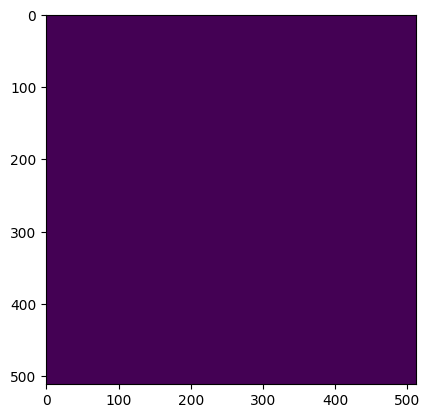

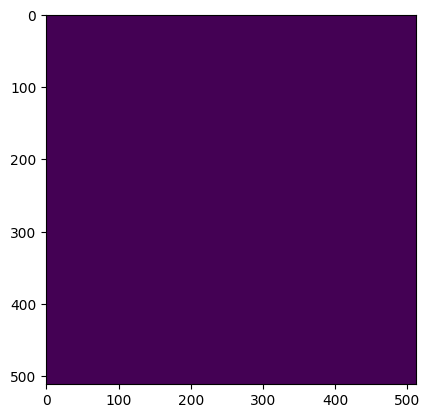

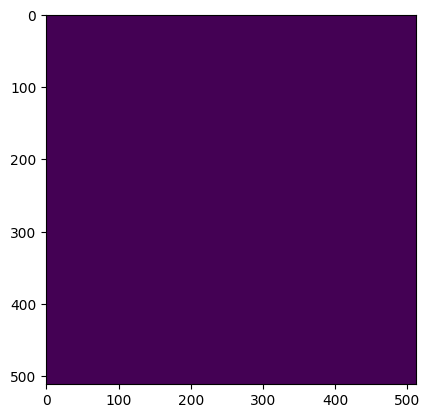

In [3]:
for i in range(34):
    plt.imshow(gt[i])
    plt.show()

In [43]:
x = torch.zeros(34,512,512)
error = 0
for i in range(512):
    for j in range(512):
        try:
            color = tuple(gt[i,j].numpy())
            id = color_mapping[color]
            x[id,i,j] = 255
        except:
            x[0,i,j] = 255

In [44]:
x = x.permute(1,2,0)

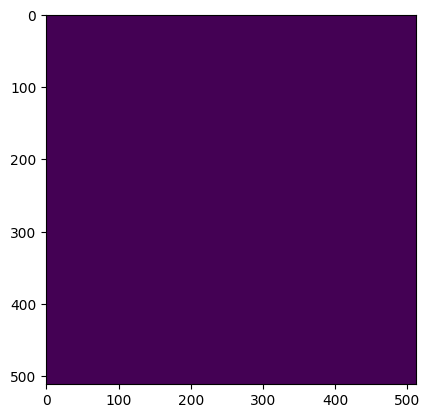

In [46]:
plt.imshow(x[:,:,11])

In [10]:
color_mapping

{(0, 0, 0): 4,
 (111, 74, 0): 5,
 (81, 0, 81): 6,
 (128, 64, 128): 7,
 (244, 35, 232): 8,
 (250, 170, 160): 9,
 (230, 150, 140): 10,
 (70, 70, 70): 11,
 (102, 102, 156): 12,
 (190, 153, 153): 13,
 (180, 165, 180): 14,
 (150, 100, 100): 15,
 (150, 120, 90): 16,
 (153, 153, 153): 18,
 (250, 170, 30): 19,
 (220, 220, 0): 20,
 (107, 142, 35): 21,
 (152, 251, 152): 22,
 (70, 130, 180): 23,
 (220, 20, 60): 24,
 (255, 0, 0): 25,
 (0, 0, 142): -1,
 (0, 0, 70): 27,
 (0, 60, 100): 28,
 (0, 0, 90): 29,
 (0, 0, 110): 30,
 (0, 80, 100): 31,
 (0, 0, 230): 32,
 (119, 11, 32): 33}